Importing Libraries & Functions

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from matplotlib.animation import FuncAnimation, FFMpegWriter
import torch.nn as nn
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.ensemble import IsolationForest
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from numpy.fft import fft, fftfreq

pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
class LSTMAE(nn.Module):
    def __init__(self, n_features, hidden=64):
        super().__init__()
        self.encoder = nn.LSTM(n_features, hidden, batch_first=True)
        self.decoder = nn.LSTM(hidden, n_features, batch_first=True)

    def forward(self, x):
        _, (h, _) = self.encoder(x)
        h = h[-1].unsqueeze(1).repeat(1, x.size(1), 1)
        out, _ = self.decoder(h)
        return out

def create_sequences(data, seq_len=20):
    xs = []
    for i in range(len(data) - seq_len):
        xs.append(data[i:i+seq_len])
    return np.array(xs)

class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        x = self.X[idx]
        return x, x  # target = input


In [3]:
def normalize_segments(df, indices):
    time_col = df['TimeStr']
    df = df[["34-2-V-O-O", "35-3-V-O-B", "38-6-WIS-O", "39-7-WIS-B", 
          "36-4-V-B-O", "37-5-V-B-B", "40-8-OMG", "33-1-Olie"]]
    out = []
    time_out = []
    for start, end in zip(indices[:-1], indices[1:]):
        seg = df.iloc[start:end].copy()
        time_col_seg = time_col.iloc[start:end].copy()
        seg = (seg - seg.mean()) / seg.std()
        out.append(seg)
        time_out.append(time_col_seg)
    return pd.concat(out), pd.concat(time_out)


In [4]:
def assign_machine_runs(df, gap_indices):

    # copy so you don't mutate original
    df_out = df.copy()
    
    gap_indices = sorted(gap_indices)
    run_labels = [0] * len(df_out)

    # define start/end for each segment
    for i in range(len(gap_indices)):
        start = gap_indices[i] + 1
        
        if i + 1 < len(gap_indices):
            end = gap_indices[i+1]
        else:
            end = len(df_out)

        # all rows in this segment get run number (1-indexed)
        for idx in range(start, end):
            run_labels[idx] = i + 1

    df_out["machine_run"] = run_labels
    return df_out


Reading DFs

In [5]:
temps_df = pd.read_feather('Temps_complete.feather')

In [6]:
temps_df = temps_df.replace(["Undef", np.nan, None], np.nan)
temps_df['TimeStr'] = pd.to_datetime(temps_df['TimeStr'], errors='coerce')
temps_df = temps_df.sort_values('TimeStr')
temps_df = temps_df.iloc[1:]
temp_columns = ['33-1-Olie', '34-2-V-O-O','35-3-V-O-B', '36-4-V-B-O', 
                '37-5-V-B-B', '38-6-WIS-O', '39-7-WIS-B','40-8-OMG']
temps_df[temp_columns] = temps_df[temp_columns].astype(float)
temps_df = temps_df.dropna(subset=temp_columns)
temps_df = temps_df.reset_index(drop=True)

In [7]:
threshold = pd.Timedelta(seconds=6)

gaps = []
for i in range(1, len(temps_df)):
    gap_length = temps_df['TimeStr'].iloc[i] - temps_df['TimeStr'].iloc[i-1]
    if gap_length > threshold:
        gaps.append({
            "gap_index": i,
            "gap_length": gap_length,
            "gap_start": temps_df['TimeStr'].iloc[i-1],
            "gap_end": temps_df['TimeStr'].iloc[i]
        })

gaps_df = pd.DataFrame(gaps)
gap_indices = gaps_df['gap_index'].tolist()

In [8]:
plot_temps = temps_df[["34-2-V-O-O", "35-3-V-O-B", "38-6-WIS-O", "39-7-WIS-B", 
          "36-4-V-B-O", "37-5-V-B-B", "40-8-OMG", "33-1-Olie"]]

#v00, vob, 6wiso, 7wiso, vbo, vbb, omg 

Visualizing

In [ ]:


temps_small = []

# ---- 1. Build proper segment boundaries ----
gap_indices = gaps_df['gap_index'].tolist()
boundaries = [0] + gap_indices + [len(temps_df)]

# ---- 2. Loop over segments correctly (N gaps => N+1 runs) ----
for run_id in range(len(boundaries)-1):
    
    start_ind = boundaries[run_id]
    end_ind   = boundaries[run_id+1]

    # normalization
    norm_df, time_col = normalize_segments(
        temps_df,
        [start_ind, end_ind]
    )

    # add time as column
    norm_df = norm_df.copy()
    norm_df["TimeStr"] = time_col

    # group per 10 minutes
    grouped = norm_df.groupby(pd.Grouper(key="TimeStr", freq='10min'))

    for window_start, group in grouped:
        if group.empty:
            continue

        # machine_run is now correct and 1:1 with real runs
        row_features = {"TimeStr": window_start, "machine_run": run_id}

        for col in norm_df.columns.drop("TimeStr"):

            series = group[col].dropna()
            if len(series) == 0:
                continue

            # === BASIC STATS ===
            mean = series.mean()
            var  = series.var()

            row_features[f'{col}_mean'] = mean
            row_features[f'{col}_median'] = series.median()
            row_features[f'{col}_variance'] = var
            row_features[f'{col}_skewness'] = skew(series, bias=False) if var > 0 else 0.0
            row_features[f'{col}_kurtosis'] = kurtosis(series, bias=False) if var > 0 else 0.0

            # === ROLLING ===
            rolling = series.rolling(3, min_periods=1)
            row_features[f'{col}_rolling_mean_3'] = rolling.mean().iloc[-1]
            row_features[f'{col}_rolling_std_3']  = rolling.std().iloc[-1]

            # === SHAPE ===
            row_features[f'{col}_num_peaks'] = len(find_peaks(series)[0])
            row_features[f'{col}_max_slope'] = (
                np.max(np.abs(np.diff(series))) if len(series) > 1 else 0.0
            )

            # === DOMAIN ===
            if len(series) > 1:
                diffs = np.diff(series)
                row_features[f'{col}_heating_rate_max']  = np.max(diffs)
                row_features[f'{col}_cooling_rate_max']  = np.min(diffs)
            else:
                row_features[f'{col}_heating_rate_max']  = 0.0
                row_features[f'{col}_cooling_rate_max']  = 0.0

            row_features[f'{col}_duration_above_mean'] = np.sum(series > mean)
            row_features[f'{col}_duration_below_mean'] = np.sum(series < mean)

            # === FREQUENCY DOMAIN ===
            if len(series) > 1 and len(np.unique(series)) > 1:
                n = len(series)
                fft_values = np.abs(fft(series))
                fft_values[0] = 0   # drop DC
                total_energy = np.sum(fft_values**2)
                sum_fft = np.sum(fft_values)
                freqs = fftfreq(n, d=1)

                row_features[f'{col}_dominant_freq']    = freqs[np.argmax(fft_values)]
                row_features[f'{col}_spectral_energy']   = total_energy
                row_features[f'{col}_spectral_centroid'] = (
                    np.sum(freqs * fft_values) / sum_fft if sum_fft != 0 else 0.0
                )
                fft_prob = fft_values / sum_fft if sum_fft != 0 else np.zeros_like(fft_values)
                row_features[f'{col}_spectral_entropy'] = (
                    -np.sum(fft_prob * np.log(fft_prob + 1e-12))
                )
            else:
                row_features[f'{col}_dominant_freq']    = 0.0
                row_features[f'{col}_spectral_energy']   = 0.0
                row_features[f'{col}_spectral_centroid'] = 0.0
                row_features[f'{col}_spectral_entropy']  = 0.0

        temps_small.append(row_features)

temps_small = pd.DataFrame(temps_small)


In [10]:
features = ['_mean', '_median', '_variance', 
            '_skewness', '_kurtosis', '_rolling_mean_3',
            '_rolling_std_3', '_num_peaks', '_max_slope', 
            '_heating_rate_max', '_cooling_rate_max', '_duration_above_mean',
            '_duration_below_mean', '_dominant_freq', '_spectral_energy',
            '_spectral_centroid', '_spectral_entropy']

sensors = ["34-2-V-O-O", "35-3-V-O-B", "38-6-WIS-O", "39-7-WIS-B", 
           "36-4-V-B-O", "37-5-V-B-B", "40-8-OMG", "33-1-Olie"]

In [11]:
new_temps_df = assign_machine_runs(temps_df[['TimeStr'] + sensors], gap_indices)

In [12]:
temps_small.columns

Index(['TimeStr', 'machine_run', '34-2-V-O-O_mean', '34-2-V-O-O_median',
       '34-2-V-O-O_variance', '34-2-V-O-O_skewness', '34-2-V-O-O_kurtosis',
       '34-2-V-O-O_rolling_mean_3', '34-2-V-O-O_rolling_std_3',
       '34-2-V-O-O_num_peaks',
       ...
       '33-1-Olie_num_peaks', '33-1-Olie_max_slope',
       '33-1-Olie_heating_rate_max', '33-1-Olie_cooling_rate_max',
       '33-1-Olie_duration_above_mean', '33-1-Olie_duration_below_mean',
       '33-1-Olie_dominant_freq', '33-1-Olie_spectral_energy',
       '33-1-Olie_spectral_centroid', '33-1-Olie_spectral_entropy'],
      dtype='object', length=138)

In [34]:
from sklearn.ensemble import IsolationForest
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import pandas as pd

all_anoms_iso = []
all_anoms_lstm = []
overfit_metrics = []

seq_len = 20
epochs = 5
batch_size = 64

# loop FEATURES instead of raw sensors
for feature in features:

    feature_cols = [f"{s}{feature}" for s in sensors]

    # skip if feature missing
    if not all(c in temps_small.columns for c in feature_cols):
        continue

    for run_id, df_run in temps_small.groupby("machine_run"):

        split = int(len(df_run) * (1/3))
        train_df = df_run.iloc[:split]
        test_df  = df_run.iloc[split:]

        X_train = train_df[feature_cols].values.astype("float32")
        X_test  = test_df[feature_cols].values.astype("float32")

        if len(X_train) < seq_len + 5:
            continue

        # ---------- Isolation Forest ----------
        iso = IsolationForest(
            n_estimators=200,
            contamination=0.01,
            random_state=42
        )
        iso.fit(X_train)

        labels_train = iso.predict(X_train)
        labels_test  = iso.predict(X_test)

        anomaly_idx_train = train_df.index[labels_train == -1]
        anomaly_idx_test  = test_df.index[labels_test == -1]

        all_anoms_iso.extend(anomaly_idx_train)
        all_anoms_iso.extend(anomaly_idx_test)

        # ---------- LSTM Autoencoder ----------
        X_seq_train = create_sequences(X_train, seq_len)
        X_seq_test  = create_sequences(X_test, seq_len)

        if len(X_seq_train) < 10:
            continue

        train_dataset = SeqDataset(X_seq_train)
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True
        )

        model = LSTMAE(
            n_features=X_seq_train.shape[2],
            hidden=64
        )
        opt = torch.optim.Adam(model.parameters(), lr=1e-3)
        loss_fn = nn.MSELoss()

        model.train()
        for _ in range(epochs):
            for xb, yb in train_loader:
                opt.zero_grad()
                out = model(xb)
                loss = loss_fn(out, yb)
                loss.backward()
                opt.step()

        model.eval()
        with torch.no_grad():
            rec_train = model(torch.tensor(X_seq_train))
            rec_test  = model(torch.tensor(X_seq_test))

        err_train = ((rec_train.numpy() - X_seq_train) ** 2).mean(axis=(1,2))
        err_test  = ((rec_test.numpy() - X_seq_test) ** 2).mean(axis=(1,2))

        thr = np.percentile(err_train, 99)

        train_idx = np.where(err_train > thr)[0] + seq_len
        test_idx  = np.where(err_test > thr)[0] + seq_len

        all_anoms_lstm.extend(train_df.index[train_idx])
        all_anoms_lstm.extend(test_df.index[test_idx])

        overfit_metrics.append({
            "machine_run": run_id,
            "feature": feature,
            "lstm_train_err": err_train.mean(),
            "lstm_test_err": err_test.mean(),
            "lstm_overfit_ratio": err_train.mean() / err_test.mean()
        })

overfit_df = pd.DataFrame(overfit_metrics)
overfit_df.to_csv("overfit_metrics.csv", index=False)
overfit_df


,machine_run,feature,lstm_train_err,lstm_test_err,lstm_overfit_ratio
0,5,_mean,0.50,1.48,0.34
1,8,_mean,1.63,0.37,4.41
2,14,_mean,0.65,0.80,0.81
3,16,_mean,1.14,0.77,1.47
4,21,_mean,0.98,0.92,1.07
...,...,...,...,...,...
80,5,_spectral_entropy,41.62,24.82,1.68
81,8,_spectral_entropy,25.70,26.35,0.98
82,14,_spectral_entropy,23.90,23.76,1.01
83,16,_spectral_entropy,26.53,26.70,0.99


In [35]:
plot_i = 1

ANOMALIES DETECTED BY ISOLATION FOREST

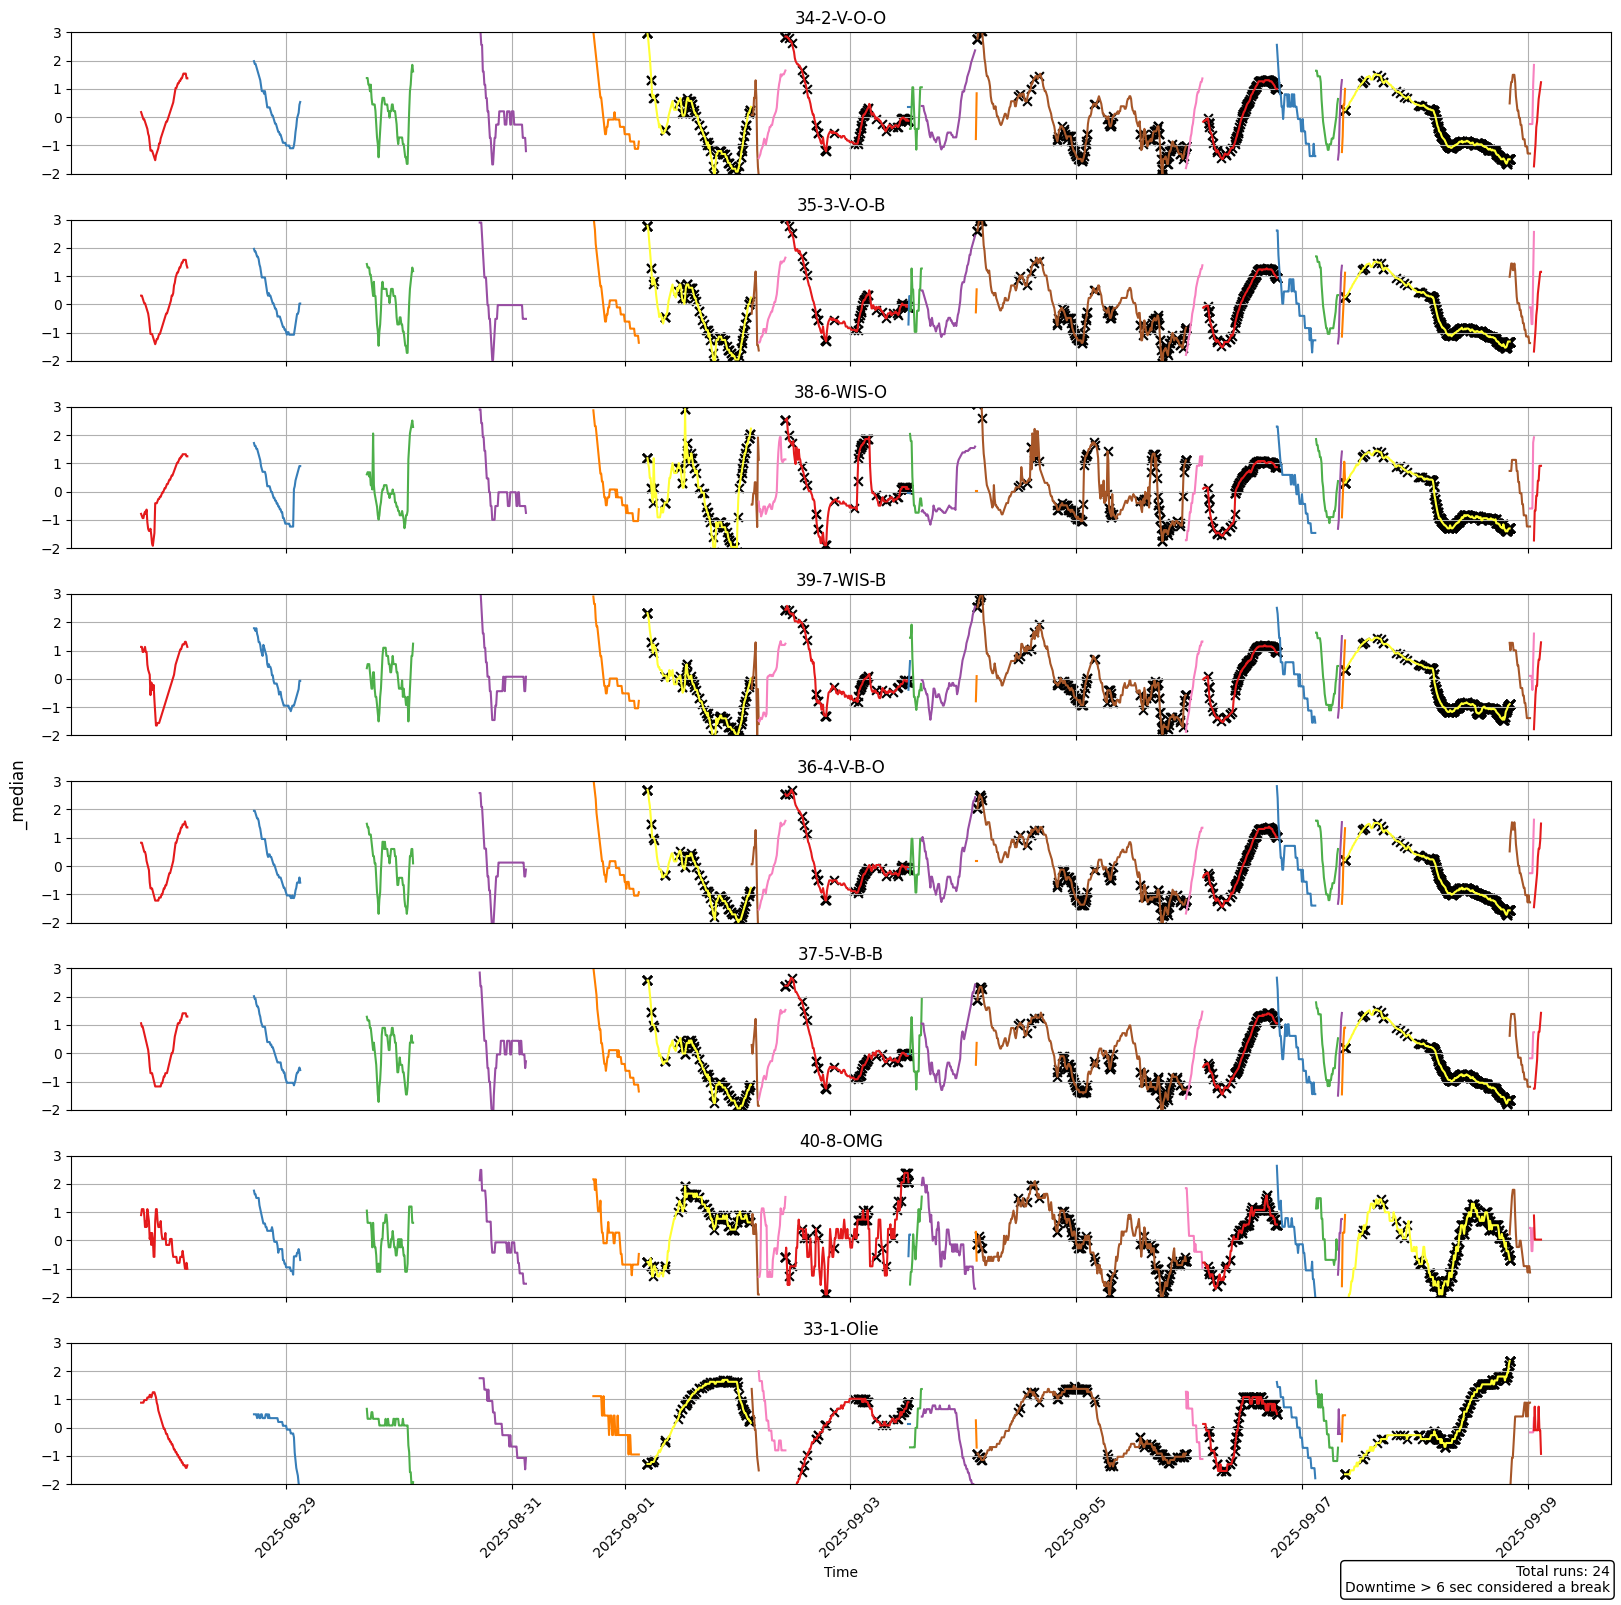

In [36]:

base_colors = [
    "#e41a1c", "#377eb8", "#4daf4a", "#984ea3",
    "#ff7f00", "#ffff33", "#a65628", "#f781bf"
]

temps_small['color'] = temps_small['machine_run'].apply(
    lambda x: base_colors[x % len(base_colors)]
)

fig, axes = plt.subplots(
    len(sensors), 1,
    figsize=(16, 2 * len(sensors)),
    sharex=True
)

for i, sensor in enumerate(sensors):
    ax = axes[i]

    # normal runs
    for run_id, group in temps_small.groupby('machine_run'):
        ax.plot(
            group['TimeStr'],
            group[f"{sensor}{features[plot_i]}"],
            c=base_colors[run_id % len(base_colors)],
            label=f'Run {run_id}'
        )

    # anomalies overlay
    # scatter the anomaly points for this sensor only
    anoms = temps_small.iloc[all_anoms_iso]
    ax.scatter(
        anoms['TimeStr'],
        anoms[f"{sensor}{features[plot_i]}"],
        s=40,
        c="black",
        marker="x",
        linewidths=1.5,
        label="anomaly"
    )

    ax.set_ylim([-2, 3])
    ax.set_title(sensor)
    ax.grid(True)

axes[-1].set_xlabel('Time')
plt.xticks(rotation=45)

fig.text(
    -0.01, 0.5,
    f'{features[plot_i]}',
    va='center', rotation='vertical', fontsize=12
)

fig.text(
    0.99, 0.0,
    f"Total runs: {len(gap_indices)}\nDowntime > 6 sec considered a break",
    ha="right", va="bottom",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black")
)

plt.tight_layout()
plt.show()


ANOMALIES LSTM

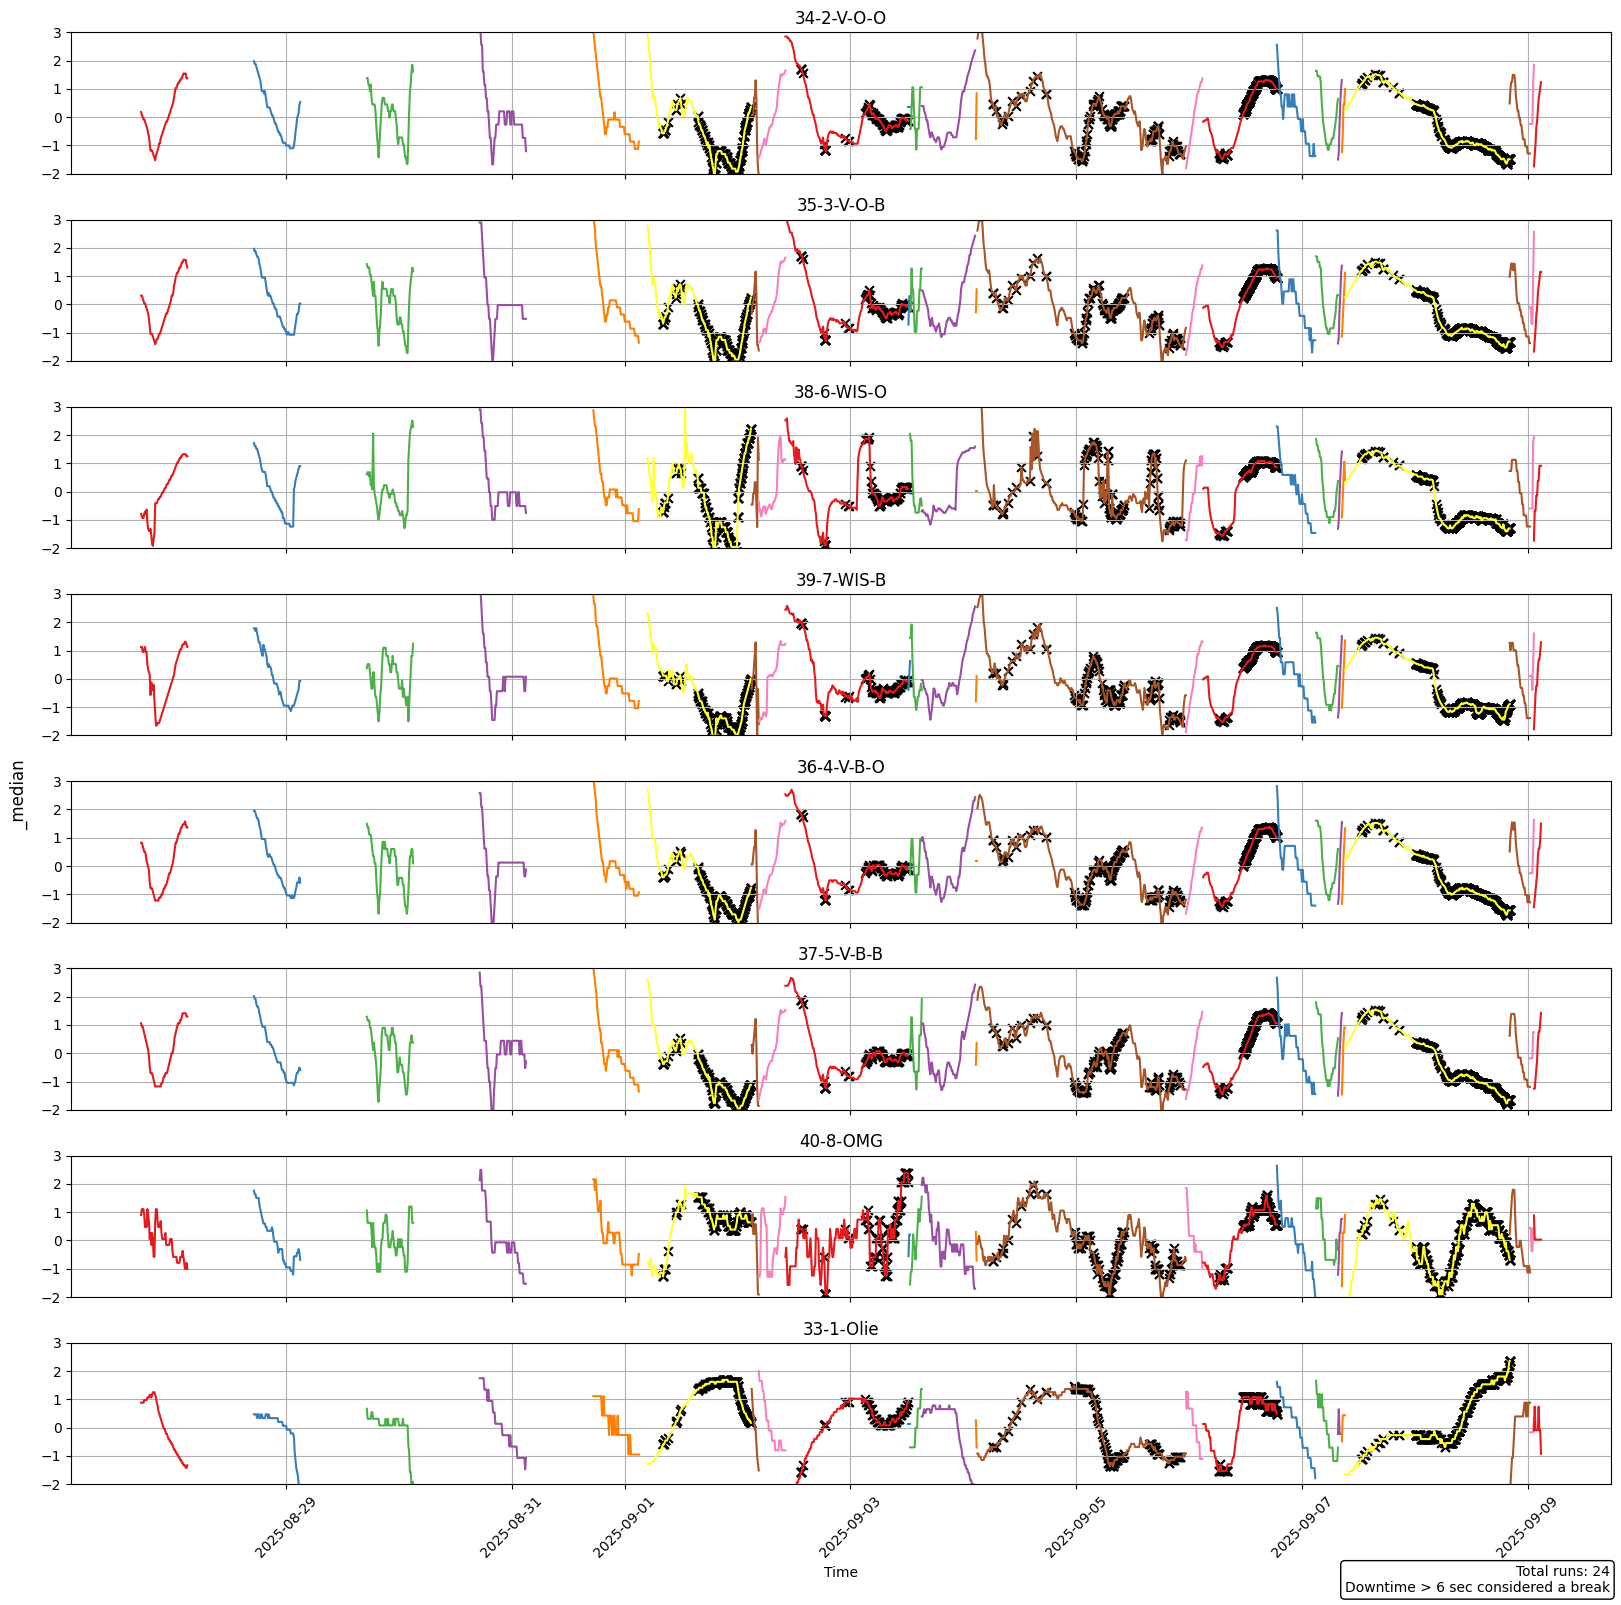

In [37]:

base_colors = [
    "#e41a1c", "#377eb8", "#4daf4a", "#984ea3",
    "#ff7f00", "#ffff33", "#a65628", "#f781bf"
]

temps_small['color'] = temps_small['machine_run'].apply(
    lambda x: base_colors[x % len(base_colors)]
)

fig, axes = plt.subplots(
    len(sensors), 1,
    figsize=(16, 2 * len(sensors)),
    sharex=True
)

for i, sensor in enumerate(sensors):
    ax = axes[i]

    # normal runs
    for run_id, group in temps_small.groupby('machine_run'):
        ax.plot(
            group['TimeStr'],
            group[f"{sensor}{features[plot_i]}"],
            c=base_colors[run_id % len(base_colors)],
            label=f'Run {run_id}'
        )

    # anomalies overlay
    # scatter the anomaly points for this sensor only
    anoms = temps_small.iloc[all_anoms_lstm]
    ax.scatter(
        anoms['TimeStr'],
        anoms[f"{sensor}{features[plot_i]}"],
        s=40,
        c="black",
        marker="x",
        linewidths=1.5,
        label="anomaly"
    )

    ax.set_ylim([-2, 3])
    ax.set_title(sensor)
    ax.grid(True)

axes[-1].set_xlabel('Time')
plt.xticks(rotation=45)

fig.text(
    -0.01, 0.5,
    f'{features[plot_i]}',
    va='center', rotation='vertical', fontsize=12
)

fig.text(
    0.99, 0.0,
    f"Total runs: {len(gap_indices)}\nDowntime > 6 sec considered a break",
    ha="right", va="bottom",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black")
)

plt.tight_layout()
plt.show()


In [ ]:

# # ---------- Main Loop Across Machine Runs ----------
# all_anoms_iso = []
# all_anoms_lstm = []
# overfit_metrics = []

# seq_len = 20
# epochs = 5
# batch_size = 64

# for run_id, df_run in new_temps_df.groupby("machine_run"):
    
#     # --------- Split into train/test 70/30 ---------
#     split = int(len(df_run) * (1/3))
#     train_df = df_run.iloc[:split]
#     test_df  = df_run.iloc[split:]

#     X_train = train_df[sensors].values.astype("float32")
#     X_test  = test_df[sensors].values.astype("float32")

#     # ---------- Isolation Forest ----------
#     print(run_id)
#     iso = IsolationForest(
#         n_estimators=200,
#         contamination=0.01,
#         random_state=42
#     )
#     iso.fit(X_train)

#     # anomalies
#     labels_train = iso.predict(X_train)
#     labels_test  = iso.predict(X_test)

#     iso_train_frac = (labels_train == -1).mean()
#     iso_test_frac  = (labels_test == -1).mean()

#     anomaly_idx_train = train_df.index[np.where(labels_train == -1)[0]]
#     anomaly_idx_test  = test_df.index[np.where(labels_test == -1)[0]]

#     all_anoms_iso.extend(list(anomaly_idx_train))
#     all_anoms_iso.extend(list(anomaly_idx_test))

#     # ---------- LSTM Autoencoder ----------
#     X_seq_train = create_sequences(X_train, seq_len)
#     X_seq_test  = create_sequences(X_test, seq_len)

#     if len(X_seq_train) < 10:  # skip tiny runs
#         continue

#     train_dataset = SeqDataset(X_seq_train)
#     test_dataset  = SeqDataset(X_seq_test)

#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#     model = LSTMAE(n_features=X_seq_train.shape[2], hidden=64)
#     opt = torch.optim.Adam(model.parameters(), lr=1e-3)
#     loss_fn = nn.MSELoss()

#     # training
#     model.train()
#     for ep in range(epochs):
#         for xb, yb in train_loader:
#             opt.zero_grad()
#             out = model(xb)
#             loss = loss_fn(out, yb)
#             loss.backward()
#             opt.step()

#     # reconstruction error
#     model.eval()
#     with torch.no_grad():
#         rec_train = model(torch.tensor(X_seq_train))
#         rec_test  = model(torch.tensor(X_seq_test))

#     err_train = ((rec_train.numpy() - X_seq_train)**2).mean(axis=(1,2))
#     err_test  = ((rec_test.numpy() - X_seq_test)**2).mean(axis=(1,2))

#     # simple anomaly threshold
#     thr = np.percentile(err_train, 99)
#     lstm_anom_train_idx = np.where(err_train > thr)[0] + seq_len
#     lstm_anom_test_idx  = np.where(err_test > thr)[0] + seq_len

#     lstm_anom_train_idx_global = train_df.index[lstm_anom_train_idx]
#     lstm_anom_test_idx_global  = test_df.index[lstm_anom_test_idx]

#     all_anoms_lstm.extend(list(lstm_anom_train_idx_global))
#     all_anoms_lstm.extend(list(lstm_anom_test_idx_global))

#     # ---------- Overfitting Assessment ----------
#     train_mean = err_train.mean()
#     test_mean  = err_test.mean()
#     overfit_metrics.append({
#         "machine_run": run_id,
#         "iso_train_frac": iso_train_frac,
#         "iso_test_frac": iso_test_frac,
#         "lstm_train_err": train_mean,
#         "lstm_test_err": test_mean,
#         "lstm_overfit_ratio": train_mean / test_mean
#     })

# # save overfit assessment
# overfit_df = pd.DataFrame(overfit_metrics)
# overfit_df.to_csv("overfit_metrics.csv", index=False)
# (overfit_df)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from matplotlib.animation import FuncAnimation, FFMpegWriter
# from matplotlib.colors import LinearSegmentedColormap, Normalize

# # ========= custom 4-color colormap =========
# points  = [-5, -1, 1, 5]
# colors  = ["navy", "deepskyblue", "orange", "red"]

# # normalize the points to 0–1
# norm_points = [(p - min(points)) / (max(points) - min(points)) for p in points]

# cmap = LinearSegmentedColormap.from_list(
#     "custom4",
#     list(zip(norm_points, colors))
# )

# norm = Normalize(vmin=-5, vmax=5)
# # ==========================================

# # sensor positions 
# xs = np.array([0.38 , 0.36, 0.38, 0.39, 0.40, 0.425, 0.8825, 0.8775])
# ys = np.array([0.1175, 0.335, 0.39, 0.4875, 0.6725, 0.8925, 0.925, 0.20])

# bg = mpimg.imread("for_plotting.png")

# for index in range(len(gaps_df['gap_index'])):

#     if index == 0:
#         start_ind = 0
#     else:
#         start_ind = gaps_df['gap_index'][index - 1]

#     # normalization
#     norm_df, time_col = normalize_segments(
#         temps_df,
#         [start_ind, gaps_df['gap_index'][index]]
#     )
#     step = max(1, len(norm_df) // 1000)  # max ~1000 frames
#     norm_df = norm_df.iloc[::step]
#     time_col = time_col.iloc[::step]

#     fig, ax = plt.subplots()
#     ax.imshow(bg, extent=[0,1,0,1])

#     # initial frame
#     temps = norm_df.iloc[0].values
#     sc = ax.scatter(xs, ys, s=150, c=temps, cmap=cmap, norm=norm)
#     cbar = fig.colorbar(sc, ax=ax)
#     cbar.set_label("Normalized Temperature")

#     # timestamp annotation
#     t = ax.text(
#         0.5, 1.03,
#         str(time_col.iloc[0]),
#         transform=ax.transAxes,
#         fontsize=12,
#         color="black",
#         ha="center",
#         va="top"
#     )

#     ax.set_axis_off()
#     plt.tight_layout()

#     def update(frame):
#         vals = norm_df.iloc[frame].values
#         sc.set_array(vals)
#         t.set_text(str(time_col.iloc[frame]))
#         return sc, t

#     # animation
#     fps = max(30, len(norm_df) / 60)  # max 1 min
#     anim = FuncAnimation(fig, update, frames=len(norm_df), blit=False)

#     writer = FFMpegWriter(fps=fps)
#     anim.save(f"heat_{index}_animation.mp4", writer=writer)

#     plt.close()


End Conclusions

1. Look at how the temps look in line plot for all sensors.
2. Use LSTM / Isolation Forest to determine anomalies in different machine runs
3. scatter Plot with PCA, t-SNE and color code based on machine run. (Done, but not fruitful)
4. Look at all animations. 
5. Find in which runs and how many times we see that one side of the machine is hotter than the other.